In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from urllib.parse import urlparse
from urllib.request import urlretrieve
import os

def load_data(url, **kwargs):
    path = urlparse(url).path
    filename = os.path.basename(path)
    if not os.path.exists(filename):
        urlretrieve(url, filename)
    return pd.read_csv(filename, **kwargs)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

In [5]:
data = load_data('https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_2/training.csv.gz')

In [6]:
data.head()
df=data

In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data.Label)
y = le.transform(data.Label).astype(np.float)
labels = np.array(le.classes_, dtype=np.str)
labels

array(['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'], dtype='<U8')

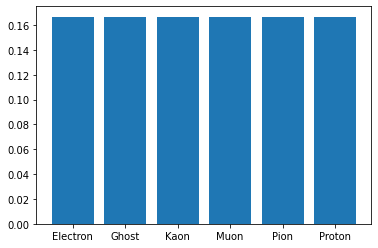

In [8]:
count = np.array([(data.Label == l).sum() for l in labels])
plt.figure()
plt.bar(np.arange(len(labels)), count / np.sum(count))
plt.xticks(np.arange(len(labels)), labels)
plt.show()

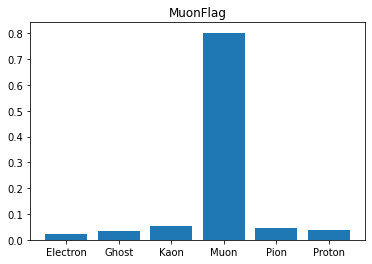

In [9]:
ratio = np.array([data[data.Label == l]["MuonFlag"].sum() for l in labels]) / count
plt.figure()
plt.title("MuonFlag")
plt.bar(np.arange(len(labels)), ratio)
plt.xticks(np.arange(len(labels)), labels)
plt.show()

In [10]:
data = data.drop(['MuonFlag'], axis = 1)


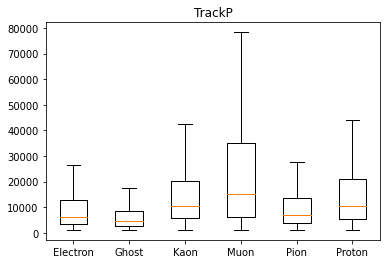

In [11]:
moment = list([data[data.Label == l]["TrackP"] for l in labels])
moment = list([x[x > -998] for x in moment])
plt.title("TrackP")
plt.boxplot(moment, showfliers=False)
plt.xticks(np.arange(len(labels))+1, labels)
plt.show()

In [12]:
data = data.drop(['TrackP'], axis = 1)


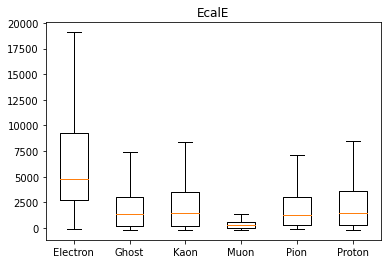

In [13]:
energy = list([data[data.Label == l]["EcalE"] for l in labels])
energy = list([x[x > -998] for x in energy])
plt.figure()
plt.title("EcalE")
plt.boxplot(energy, showfliers=False)
plt.xticks(np.arange(len(labels))+1, labels)
plt.show()

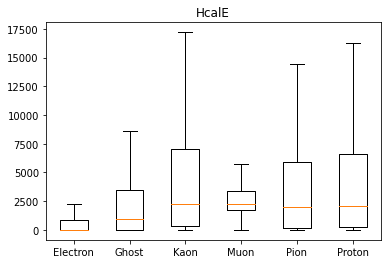

In [14]:
energy = list([data[data.Label == l]["HcalE"] for l in labels])
energy = list([x[x > -998] for x in energy])
plt.figure()
plt.title("HcalE")
plt.boxplot(energy, showfliers=False)
plt.xticks(np.arange(len(labels))+1, labels)
plt.show()

In [15]:
data = data.drop(['HcalE'], axis = 1)

In [17]:

features = np.asarray(list(set(data.columns) - {'Label',}))
x = np.asarray(data[features])

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size=0.7)

## Нейросети

In [19]:
import tensorflow as tf
tf.random.set_seed(47)

In [28]:
INPUT_DIM  = x_train.shape[1]
HIDDEN_DIM = 100
OUTPUT_DIM = len(labels)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="sigmoid"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation="sigmoid"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation="sigmoid"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUTPUT_DIM, activation="softmax"),
])

learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC()
              ])

model.fit(x_train, tf.keras.utils.to_categorical(y_train, num_classes=len(labels)),
          epochs=5, batch_size=12,
          validation_data=(x_test, tf.keras.utils.to_categorical(y_test, num_classes=len(labels)))
         )

Epoch 1/5
70000/70000 [==============================] - 171s 2ms/step - loss: 1.4562 - accuracy: 0.3871 - auc_1: 0.7512 - val_loss: 1.1369 - val_accuracy: 0.5230 - val_auc_1: 0.8656
Epoch 2/5
70000/70000 [==============================] - 170s 2ms/step - loss: 1.1412 - accuracy: 0.5262 - auc_1: 0.8652 - val_loss: 0.9820 - val_accuracy: 0.5834 - val_auc_1: 0.9020
Epoch 3/5
70000/70000 [==============================] - 168s 2ms/step - loss: 1.0356 - accuracy: 0.5652 - auc_1: 0.8905 - val_loss: 0.9432 - val_accuracy: 0.5925 - val_auc_1: 0.9093
Epoch 4/5
70000/70000 [==============================] - 171s 2ms/step - loss: 1.0044 - accuracy: 0.5751 - auc_1: 0.8970 - val_loss: 0.9239 - val_accuracy: 0.5962 - val_auc_1: 0.9127
Epoch 5/5
70000/70000 [==============================] - 170s 2ms/step - loss: 0.9878 - accuracy: 0.5797 - auc_1: 0.9003 - val_loss: 0.9223 - val_accuracy: 0.5983 - val_auc_1: 0.9129


In [29]:
import sklearn
from sklearn.metrics import roc_curve , roc_auc_score
scores = model.predict(x_test)

roc = {}
auc = {}
for l, label in enumerate(labels):
    lscores = scores[:,l]
    one_y_test = np.asarray((y_test == l).astype(np.float))
    
    fpr, tpr, _ = sklearn.metrics.roc_curve(one_y_test, lscores)
    roc[l] = {"tpr": tpr, "fpr": fpr}
    auc[l] = sklearn.metrics.roc_auc_score(one_y_test, lscores) 

In [30]:
auc

{0: 0.9741099920218163,
 1: 0.8184936495627287,
 2: 0.8499059186254301,
 3: 0.9756278708748067,
 4: 0.915056735510867,
 5: 0.8539806692082038}

### График ROC

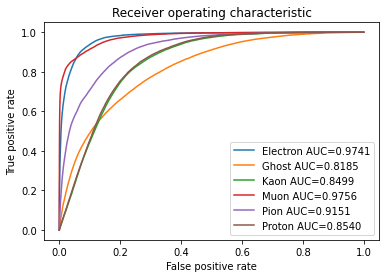

In [31]:
plt.figure()
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
for l, label in enumerate(labels):
    plt.plot(roc[l]['fpr'], roc[l]['tpr'], label='{} AUC={:.4f}'.format(label, auc[l]))
_ = plt.legend(loc='lower right')

### Распределение скоров для настоящих классов

Видно, что электроны кучкуются в правой части графика, а не электроны кучкуются в левой части. Уже лучше, но в середине они все-равно перекрываются.

### Матрица ошибок

Запутывание свелось к минимуму

              precision    recall  f1-score   support

    Electron       0.82      0.79      0.81     59956
       Ghost       0.48      0.45      0.47     59910
        Kaon       0.35      0.09      0.15     59992
        Muon       0.84      0.84      0.84     60237
        Pion       0.57      0.73      0.64     59940
      Proton       0.44      0.69      0.54     59965

    accuracy                           0.60    360000
   macro avg       0.58      0.60      0.57    360000
weighted avg       0.58      0.60      0.57    360000



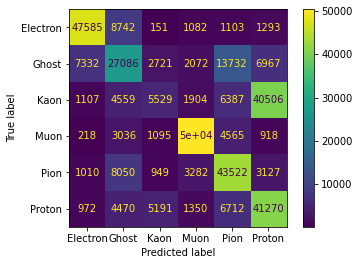

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_true = y_test
y_pred = model.predict(x_test).argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)

cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
_ = cmd.plot()

In [33]:
auc[0]

0.9741099920218163